In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data_dir = "/home/angps/Documents/Thesis/Data/"
image_dir = "/home/angps/Documents/Thesis/Report/Images/"

In [2]:
df_atleast_50_cts = pd.read_csv(data_dir + 'data_>=50cts.csv')
full_df = pd.read_csv(data_dir + 'data.csv')

In [3]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [4]:
train_df = df_atleast_50_cts.iloc[:, 0:162]
test_df = df_atleast_50_cts.iloc[:, 162:]

In [7]:
train_df = train_df.T

In [8]:
train_df.shape

(162, 42)

In [9]:
model = VAR(train_df)

/home/angps/anaconda3/envs/deeplearning2/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [11]:
for i in [1,2]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  1.6763310311329356
BIC :  36.24164956008909
FPE :  9.335589611084258
HQIC:  15.71125448172436 

Lag Order = 2
AIC :  -3.508452577148823
BIC :  65.10636317525592
FPE :  4.878761990479498
HQIC:  24.35364694691615 



In [13]:
x = model.select_order(maxlags=2)
x.summary()

,AIC,BIC,FPE,HQIC
0,5.500,6.308*,244.8,5.828*
1,1.292,36.00,6.428,15.39
2,-3.508*,65.11,4.879*,24.35


In [56]:
model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 21, Dec, 2019
Time:                     03:15:21
--------------------------------------------------------------------
No. of Equations:         42.0000    BIC:                    36.2416
Nobs:                     161.000    HQIC:                   15.7113
Log likelihood:          -7923.81    FPE:                    9.33559
AIC:                      1.67633    Det(Omega_mle):     0.000449119
--------------------------------------------------------------------
Results for equation 0
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         1.980896         0.365723            5.416           0.000
L1.0         -0.121659         0.119968           -1.014           0.311
L1.1         -0.112807         0.217252           -0.519           0.604
L1.2         -0.053186 

In [57]:
def adjust(val, length= 6): 
    return str(val).ljust(length)
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(train_df.columns, out):
    print(adjust(col), ':', round(val, 2))

0      : 2.12
1      : 1.99
2      : 2.02
3      : 2.19
4      : 1.83
5      : 1.96
6      : 2.19
7      : 2.01
8      : 2.08
9      : 2.09
10     : 1.93
11     : 2.03
12     : 2.11
13     : 1.99
14     : 2.04
15     : 2.01
16     : 2.17
17     : 2.11
18     : 2.11
19     : 2.01
20     : 2.04
21     : 1.79
22     : 2.02
23     : 1.87
24     : 2.06
25     : 2.02
26     : 1.94
27     : 1.95
28     : 1.96
29     : 2.32
30     : 2.12
31     : 1.84
32     : 1.95
33     : 2.35
34     : 2.11
35     : 2.01
36     : 2.06
37     : 1.98
38     : 1.97
39     : 2.14
40     : 2.26
41     : 2.08


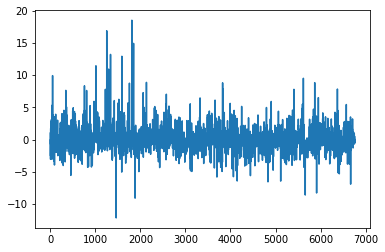

In [58]:
plt.plot(model_fitted.resid.values.flatten())

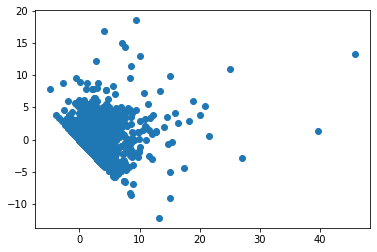

In [59]:
plt.scatter(model_fitted.fittedvalues.values.flatten(), model_fitted.resid.values.flatten())

In [60]:
forecast_input = train_df.values[-2:]
forecast_input

array([[1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 3, 4, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [61]:
fc = model_fitted.forecast(y=forecast_input, steps=42)
# df_forecast = pd.DataFrame(fc, index=df_atleast_50_cts.T.index[-42:], columns=df_atleast_50_cts.T.columns + '_2d')
# df_forecast

In [62]:
fc.shape

(42, 42)

In [63]:
def compute_errors(pred, act):
    err = np.square(np.subtract(pred, act)).sum()
    return err

In [64]:
act = df_atleast_50_cts.iloc[:,162:].T
act.shape

(42, 42)

In [65]:
loss = []
fitted = []
SFE = 0
for i in range(len(act)):
    forecast = fc[i]
    actual = act[i]
    loss.extend(forecast-actual)
    forecast_err = compute_errors(forecast, actual)
    #forecast_err = compute_errors(forecast, train)
    SFE += forecast_err
print("MSFE for baseline ARIMA model on subset of dataset: " + str(round(SFE/42, 3)))

MSFE for baseline ARIMA model on subset of dataset: 106.091
